In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
# %load_ext nb_black

from pathlib import Path
import sys

sys.path.insert(0, Path().absolute().parent.as_posix())

/Users/ruizhechao/Documents/NNforHJB


/Users/ruizhechao/Documents/NNforHJB/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# load the data
import numpy as np

path = 'rawdata/raw_data/VDP_beta_0.1_grid_30x30.npy'
data = np.load(path)
data.dtype

dtype([('x', '<f8', (2,)), ('dv', '<f8', (2,)), ('v', '<f8')])

In [3]:
# prepare the data
# data is a structured numpy array with fields: 'x', 'dv', 'v'
# convert to the dict format expected by model._prepare_data

data_dict = {
    "x": np.asarray(data["x"], dtype=np.float64),    # shape (N, 2)
    "v": np.asarray(data["v"], dtype=np.float64),    # shape (N,)
    "dv": np.asarray(data["dv"], dtype=np.float64),  # shape (N, 2)
}

### Test the PDPA algorithm

In [4]:
import torch
from scr.PDPA import PDPA

pdpa_1 = PDPA(
    data = data_dict,
    alpha = 1e-3, 
    gamma = 5.0,
    power = 2.1,
    activation = torch.relu,
    loss_weights = [1.0, 0.0],
    verbose=True
)

best_iteration_1 = pdpa_1.retrain(
    num_iterations = 20, 
    num_insertion= 5, 
    threshold = 1e-10,
    )

2026-01-12 22:21:01.641 | INFO     | scr.model:__init__:71 - Model initialized
2026-01-12 22:21:01.641 | INFO     | scr.model:__init__:71 - Model initialized
2026-01-12 22:21:01.642 | INFO     | scr.model:_prepare_data:101 - Training set: 810 samples, Validation set: 90 samples
2026-01-12 22:21:01.643 | INFO     | scr.PDPA:retrain:293 - Iteration 1 - Starting...
2026-01-12 22:21:01.643 | INFO     | scr.model:_create_network:140 - Creating network with 5 neurons
2026-01-12 22:21:02.147 | INFO     | scr.model:train:252 - Starting network training session
2026-01-12 22:21:02.159 | INFO     | scr.model:train:316 - Epoch 0: Train Loss = 23.377478, Val Loss = 35.520217
2026-01-12 22:21:02.208 | INFO     | scr.model:train:316 - Epoch 100: Train Loss = 3.616092, Val Loss = 6.685548
2026-01-12 22:21:02.255 | INFO     | scr.model:train:316 - Epoch 200: Train Loss = 1.188516, Val Loss = 2.328139
2026-01-12 22:21:02.302 | INFO     | scr.model:train:316 - Epoch 300: Train Loss = 0.610317, Val Loss 

In [5]:
best_iteration_1

11

## Test effect of different gamma

In [6]:
gammas = [10.0, 5.0, 1.0, 1e-1, 1e-2]

pdpa_list_l2 = []
best_iteration_l2 = []
for gamma in gammas:
    pdpa = PDPA(
        data=data_dict,
        alpha=1e-3,
        gamma=gamma,
        power=2.1,
        activation=torch.relu,
        loss_weights=[1.0, 0.0],
        verbose=False,
    )

    best_iteration = pdpa.retrain(
    num_iterations = 20, 
    num_insertion= 5, 
    threshold = 1e-10,
    verbose=False
    )

    pdpa_list_l2.append(pdpa)
    best_iteration_l2.append(best_iteration)


In [7]:
pdpa_list_h1 = []
best_iteration_h1 = []

for gamma in gammas:
    pdpa = PDPA(
        data=data_dict,
        alpha=1e-3,
        gamma=gamma,
        power=2.1,
        activation=torch.relu,
        loss_weights=[1.0, 1.0],
        verbose=False,
    )

    best_iteration = pdpa.retrain(
    num_iterations = 20, 
    num_insertion= 5, 
    threshold = 1e-10,
    verbose=False
    )

    pdpa_list_h1.append(pdpa)
    best_iteration_h1.append(best_iteration)

In [ ]:
import pickle

model_l2 = {
    "gammas": gammas,
    "pdpa_list_l2": pdpa_list_l2,
}

model_h1 = {
    "gammas": gammas,
    "pdpa_list_h1": pdpa_list_h1,
}


with open("models/pdpa_vdp_model_l2.pkl", "wb") as f:
    pickle.dump(model_l2, f)

with open("models/pdpa_vdp_model_h1.pkl", "wb") as f:
    pickle.dump(model_h1, f)

In [22]:
best_iteration_l2

[16, 0, 14, 9, 11]

In each iteration we tried to add 5 neurons. The following plots indicates the relation of loss & number of neurons. 

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PDPA validation loss history by γ'}, xlabel='Iteration', ylabel='Validation loss'>)

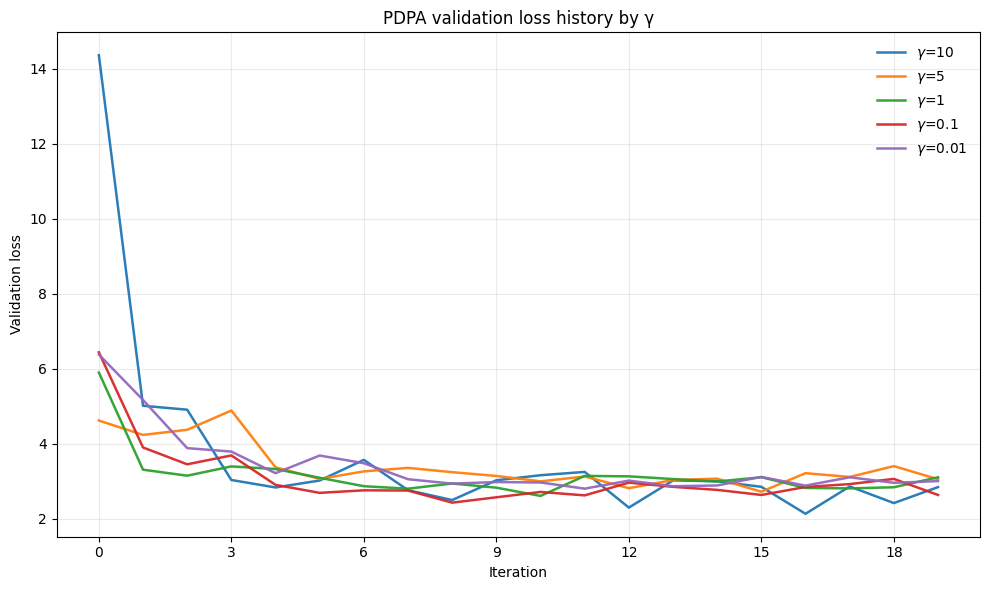

In [20]:
from scr.metric import plot_pdpa_val_loss_histories_by_gamma

plot_pdpa_val_loss_histories_by_gamma(model_h1)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PDPA validation loss history by γ'}, xlabel='Iteration', ylabel='Validation loss'>)

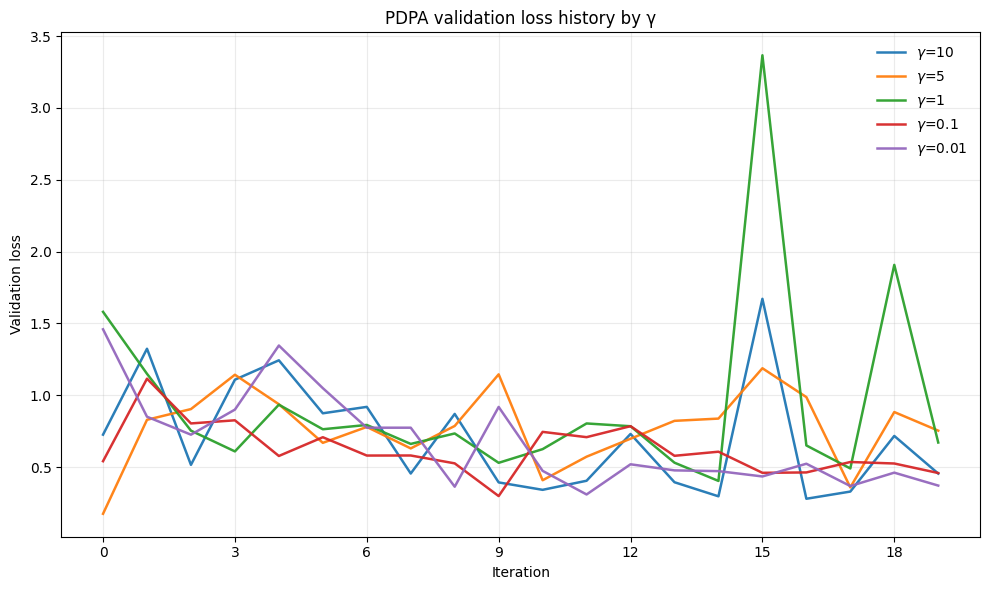

In [24]:
plot_pdpa_val_loss_histories_by_gamma(model_l2, pdpa_key="pdpa_list_l2")